In [1]:
import json
import pandas as pd
import japanize_matplotlib

In [2]:
# import data, shape as one df
def import_data(team_name: str) -> pd.DataFrame:
    with open(f'data_collection/player_stats/{team_name}.json', 'r', encoding='utf-8"') as file:
        json_data = json.load(file)
    
    with open('batter_metrics.json', 'r') as metrics_file:
        metrics = json.load(metrics_file)
    
    data_list = []
    for player_id, player_data in json_data.items():
        name = player_data['name']
        for year, stats in player_data['stats'].items():
            row = {
                'PlayerID': player_id,
                'Name': name,
                'Year': year
            }
            for metric in metrics:
                row[metric] = stats.get(metric, None)
            data_list.append(row)
    
    return pd.DataFrame(data_list)

### Quick Inspection

In [3]:
yakult_df = import_data('ヤクルト')
yakult_df.head()

,PlayerID,Name,Year,TeamCD,BattingAverage,Game,PlateAppearance,AtBat,Run,Hit,...,HitByPitch,SacrificeHit,SacrificeFly,StolenBase,CaughtStealing,DoublePlay,Error,Slugging,OnBase,Ops
0,600011,川端 慎吾,2023,2,0.319,80,105,94,4,30,...,1,1,0,0,0,4,1,0.415,0.385,0.800
1,600011,川端 慎吾,2022,2,0.175,52,64,57,1,10,...,1,0,2,0,0,1,0,0.193,0.234,0.427
2,600011,川端 慎吾,2021,2,0.372,91,93,86,8,32,...,0,0,0,0,0,2,1,0.488,0.419,0.908
3,600011,川端 慎吾,2020,2,0.128,39,42,39,3,5,...,0,0,0,0,0,1,0,0.128,0.190,0.319
4,600011,川端 慎吾,2019,2,0.164,37,67,61,5,10,...,0,0,1,0,0,2,2,0.180,0.224,0.404


In [8]:
yakult_df.describe()

,BattingAverage,Game,PlateAppearance,AtBat,Run,Hit,Double,Triple,Homerun,Base,...,HitByPitch,SacrificeHit,SacrificeFly,StolenBase,CaughtStealing,DoublePlay,Error,Slugging,OnBase,Ops
count,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,...,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000
mean,0.246709,85.154545,307.654545,268.618182,37.890909,74.409091,12.954545,1.172727,8.236364,114.418182,...,3.254545,3.509091,1.572727,5.600000,1.881818,5.763636,3.500000,0.361791,0.319982,0.681836
std,0.077684,48.281511,229.155788,199.404526,34.752690,61.175233,11.799072,1.531678,11.423400,100.559388,...,3.870463,4.967316,1.639306,8.840275,2.489360,4.731172,4.409643,0.137296,0.082777,0.212380
min,0.000000,1.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.226250,43.500000,92.250000,81.500000,7.250000,17.000000,2.000000,0.000000,0.000000,25.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.292000,0.282750,0.572500
50%,0.255000,94.000000,281.000000,246.000000,26.500000,57.500000,9.000000,1.000000,3.000000,89.000000,...,2.000000,1.000000,1.000000,2.000000,1.000000,6.000000,2.000000,0.362500,0.333000,0.696000
75%,0.298000,130.000000,515.750000,468.500000,55.750000,127.000000,22.750000,2.000000,13.000000,209.750000,...,5.000000,6.000000,3.000000,6.750000,3.000000,10.000000,5.000000,0.443500,0.372500,0.820000
max,0.412000,146.000000,685.000000,599.000000,130.000000,209.000000,44.000000,7.000000,56.000000,346.000000,...,19.000000,22.000000,7.000000,41.000000,12.000000,18.000000,22.000000,0.710000,0.458000,1.168000


### Find players with gap in 'Year' (missing data)

In [20]:
def find_gap_years(df: pd.DataFrame):
    df_copy = df.copy()
    df_copy['year_num'] = pd.to_numeric(df['Year'], errors='coerce')
    gaps = df.groupby('PlayerID')['year_num'].apply(lambda x: x.diff().fillna(-1).eq(-1).all())
    players_with_gap = gaps[~gaps].index.tolist()
    
    for player_id in players_with_gap:
        player_name = json_data.get(player_id, {}).get('name', None)
        available_years = df[df['PlayerID'] == player_id]['year_num'].tolist()
        all_years = set(range(available_years[-1], available_years[0] + 1))
        missing_years = all_years - set(available_years)
        print(f"Player ID: {player_id}, Name: {player_name}, Missing years: {sorted(missing_years)}")

In [21]:
find_gap_years(yakult_df)

Player ID: 1800036, Name: 濱田　太貴, Missing years: [2021]
Player ID: 400021, Name: 青木　宣親, Missing years: [2012, 2013, 2014, 2015, 2016, 2017]
Player ID: 600011, Name: 川端　慎吾, Missing years: [2017]


Why did they have missing data?
* 濱田太貴 (Taiki Hamada): Poor condition in upper body (https://www.daily.co.jp/baseball/2021/03/20/0014166956.shtml)
* 青木宣親 (Norichika Aoki): Were in the major league from 2012-2017 (https://www.mlb.com/player/norichika-aoki-493114)
* 川端慎吾 (Shingo Kawabata): Underwent surgery due to spinal disc herniation (https://www.sponichi.co.jp/baseball/news/2017/08/17/kiji/20170817s00001173256000c.html)

### Number of players with plate appearance >= 100 in 2023 season

Only assess teams in Central League

In [4]:
hanshin_df = import_data('阪神')
hiroshima_df = import_data('広島')
dena_df = import_data('DeNA')
kyojin_df = import_data('巨人')
chunichi_df = import_data('中日')

In [22]:
def get_high_pa_player_num(df: pd.DataFrame) -> int:
    return len(df['Name'].unique())

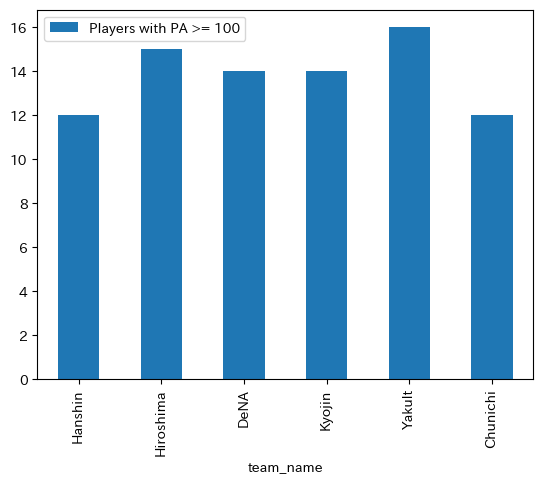

In [33]:
high_pa_player_df = pd.DataFrame({
    'team_name': ['Hanshin', 'Hiroshima', 'DeNA', 'Kyojin', 'Yakult', 'Chunichi'],
    'high_pa_players': [
        get_high_pa_player_num(hanshin_df),
        get_high_pa_player_num(hiroshima_df),
        get_high_pa_player_num(dena_df),
        get_high_pa_player_num(kyojin_df),
        get_high_pa_player_num(yakult_df),
        get_high_pa_player_num(chunichi_df)
    ]
})

ax = high_pa_player_df.plot.bar(x='team_name', y='high_pa_players')
ax.legend(['Players with PA >= 100'])

Tokyo Yakult Swallows seems to have more players with plate appearance >= 100 compared to other teams, especially Chunichi Dragons.
Since the teams are displayed in the order of final ranking, it doesn't appear that the number of players with high number of plate appearance affect team performance.

### On-base percentage in 2023 season
Inspired by the movie Moneyball -- all Billy cared about was on-base percentage

In [5]:
frames = [hanshin_df, hiroshima_df, dena_df, kyojin_df, yakult_df, chunichi_df]
combined_df = pd.concat(frames)
combined_df.head()

,PlayerID,Name,Year,TeamCD,BattingAverage,Game,PlateAppearance,AtBat,Run,Hit,...,HitByPitch,SacrificeHit,SacrificeFly,StolenBase,CaughtStealing,DoublePlay,Error,Slugging,OnBase,Ops
0,1600113,大山 悠輔,2023,5,0.288,143,625,513,80,148,...,5,0,8,3,3,13,9,0.456,0.403,0.859
1,1600113,大山 悠輔,2022,5,0.267,124,510,439,54,117,...,6,1,5,0,1,17,6,0.469,0.358,0.827
2,1600113,大山 悠輔,2021,5,0.260,129,512,466,55,121,...,2,0,7,2,1,15,10,0.453,0.313,0.765
3,1600113,大山 悠輔,2020,5,0.288,116,471,423,66,122,...,5,1,1,1,3,15,6,0.560,0.357,0.918
4,1600113,大山 悠輔,2019,5,0.258,143,587,538,52,139,...,5,1,4,3,0,12,20,0.401,0.312,0.714


In [10]:
combined_df.dtypes

PlayerID            object
Name                object
Year                object
TeamCD              object
BattingAverage     float64
Game                 int64
PlateAppearance      int64
AtBat                int64
Run                  int64
Hit                  int64
Double               int64
Triple               int64
Homerun              int64
Base                 int64
RunsBattingIn        int64
StrikeOut            int64
BaseOnBall           int64
HitByPitch           int64
SacrificeHit         int64
SacrificeFly         int64
StolenBase           int64
CaughtStealing       int64
DoublePlay           int64
Error                int64
Slugging           float64
OnBase             float64
Ops                float64
dtype: object

In [11]:
combined23_df = combined_df[combined_df['Year'] == '2023']
combined23_df.head()

,PlayerID,Name,Year,TeamCD,BattingAverage,Game,PlateAppearance,AtBat,Run,Hit,...,HitByPitch,SacrificeHit,SacrificeFly,StolenBase,CaughtStealing,DoublePlay,Error,Slugging,OnBase,Ops
0,1600113,大山 悠輔,2023,5,0.288,143,625,513,80,148,...,5,0,8,3,3,13,9,0.456,0.403,0.859
7,1800065,近本 光司,2023,5,0.285,129,585,501,83,143,...,12,0,5,28,3,6,0,0.429,0.379,0.809
12,2000056,中野 拓夢,2023,5,0.285,143,660,575,80,164,...,2,21,5,20,12,5,9,0.343,0.349,0.692
15,1800067,木浪 聖也,2023,5,0.267,127,470,408,41,109,...,4,20,7,0,0,13,10,0.333,0.320,0.653
20,2000051,佐藤 輝明,2023,5,0.263,132,548,486,70,128,...,4,0,4,7,5,4,20,0.498,0.339,0.837


In [ ]:
combine